# Proposed modification
Simulations with proposed regularization, for several $\eta$ and $\varepsilon$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tk
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF


import scipy.stats as sc
from scipy.stats import ks_2samp
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance
from scipy.special import erfinv

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker

import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 20})

---
### 1. Parameters

In [2]:
Neps = int(50)
Neta = int(200)
Niter = int(1e4)
a0 = 2
var = .8
std = np.sqrt(var)
z0 = 1

TS = np.zeros((Niter,Neps,Neta))
CS = np.zeros((Niter,Neps,Neta))
N_conv = np.zeros((Neps,Neta))

Epsilons = np.logspace(-3,0.3,Neps)
Etas = np.logspace(-3,0.3,Neta)

---
### 2. Simulation

In [3]:
beta = np.random.randn(Niter)
beta = np.sqrt(var)*beta
# simulations for different eta,eps are driven by same noise source for comparison

for l,eta in enumerate(Etas):
    for k,eps in enumerate(Epsilons):

        def controller(t,c,z,eps,eta):
            if np.abs(z[t+1]/z[t])<=eps:
                return c[t]+z[t+1]/z[t]
            if np.abs(z[t+1]/z[t])>eps:
                return c[t] + eta*np.sign(z[t+1]/z[t])

        z = np.zeros(Niter)
        z[0] = z0
        z[1] = a0*z[0] + beta[0]

        c = np.zeros(Niter)
        c[0] = 0
        c[1] = 0 + z[1]/z[0]

        z[2] = (a0-c[1])*z[1]+beta[1]
        c[2] = c[1] + controller(1,c,z,eps,eta)

        for t in range(2,Niter-1):
            z[t+1] = (a0-c[t])*z[t] + beta[t]
            c[t+1] = controller(t,c,z,eps,eta) 
            
        TS[:,k,l] = z
        CS[:,k,l] = c
    #np.savetxt("Data/eps_eta_TS/CN_eps_eta_TS_{:}.csv".format(l), TS[:,:,l], delimiter=" ")

In [4]:
#for i in range(len(Etas)):
#    TS[:,:,i]=np.loadtxt("Data/eps_eta_TS/CN_eps_eta_TS_{:}.csv".format(i))

---
### 3. Plots

##### 3.1 Quantiles

In [5]:
p=.99

In [6]:
qp = 1/(1-p) # 99% quantile of Pareto distribution with mu=1
qn = std*np.sqrt(2)*erfinv(2*p-1) # 99% quantile of normal distribution
print(qp,qn)

99.99999999999991 2.0807487942669756


In [7]:
q=np.quantile(TS[1000:,:,:],p,axis=0)

In [8]:
mn = std*np.sqrt(2*np.log(Niter))

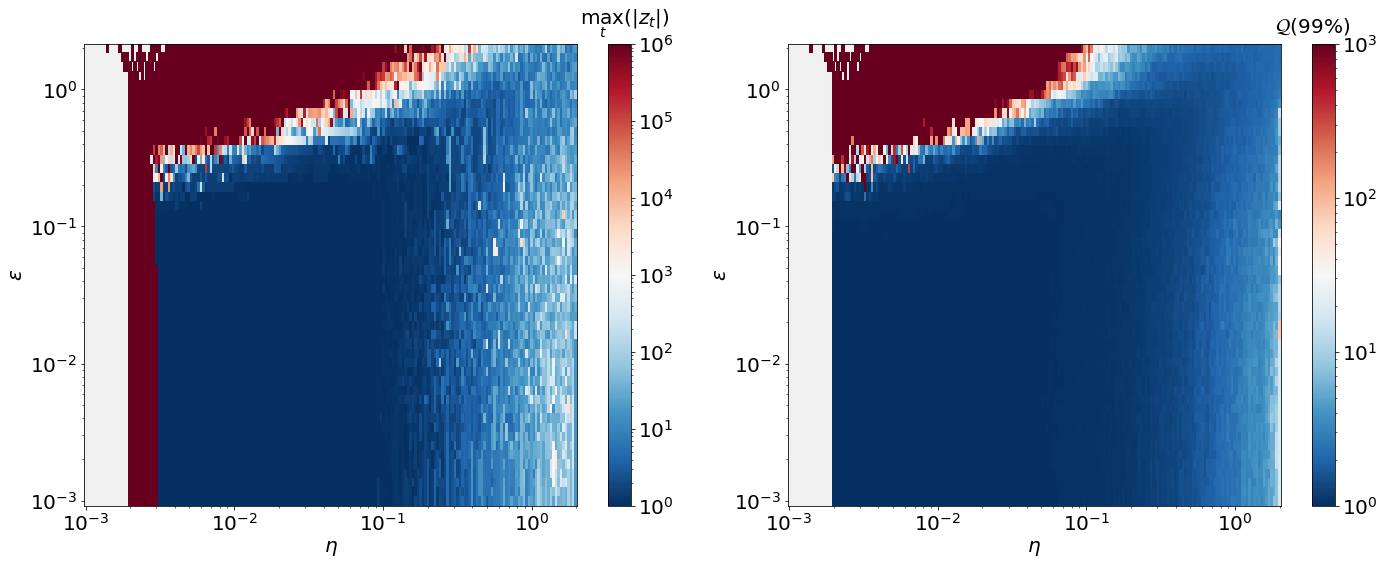

In [9]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))

maxz = np.max(np.abs(TS[1000:,:,:]),axis=0)
pcm = ax[0].pcolor(Etas,Epsilons,maxz/mn,norm=colors.LogNorm(vmin=1e0,vmax=1e6),cmap='RdBu_r', shading='auto')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$\varepsilon$')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_facecolor([240/255,240/255,240/255])


cbar = fig.colorbar(pcm, ax=ax[0])
cbar.set_label(r'$\max_t(\vert z_t\vert )$', labelpad=-49, y=1.08, rotation=0)



pcm = ax[1].pcolor(Etas,Epsilons,q/qn,norm=colors.LogNorm(vmin=1,vmax=1e3),cmap='RdBu_r', shading='auto')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel(r'$\varepsilon$')
ax[1].set_xlabel(r'$\eta$')

ax[1].set_facecolor([240/255,240/255,240/255])

cbar = fig.colorbar(pcm, ax=ax[1])
cbar.set_label(r'$\mathcal{Q}(99\%)$', labelpad=-65, y=1.06, rotation=0)

plt.tight_layout();
#plt.savefig('GraphsR5/max_quant_eta-eps.pdf',dpi=300)

In [10]:
neps=np.argmin((.1-Epsilons)**2)
neta=30
etamin = 37
print(Epsilons[neps],Etas[neta],Etas[etamin])

0.10481131341546863 0.0031440354715915 0.004107407948440236


In [11]:
print(mn,qn)

3.8388207297504646 2.0807487942669756


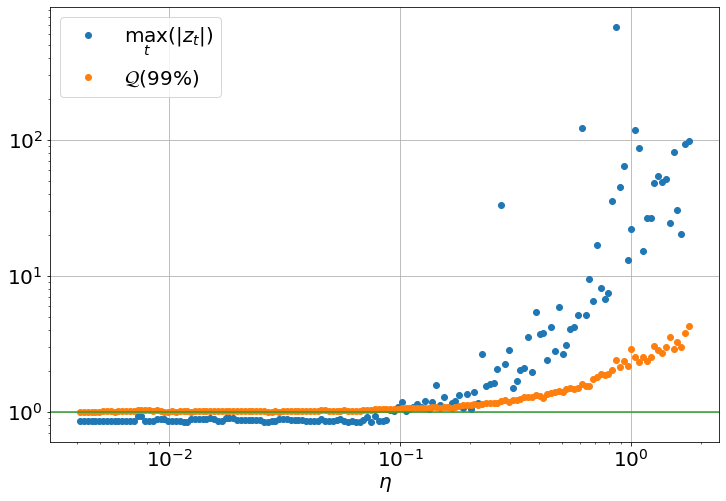

In [12]:
fig = plt.figure(figsize=(12,8))
plt.plot(Etas[etamin:-3],maxz[neps,etamin:-3]/mn,'o',label=r'$\max_t(\vert z_t\vert )$')
plt.plot(Etas[etamin:-3],q[neps,etamin:-3]/qn,'o',label=r'$\mathcal{Q}(99\%)$')
plt.axhline(1,color='tab:green')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\eta$')
plt.grid()
plt.legend();
#plt.savefig('GraphsR5/quant_max_eps_fixed.pdf')

In [13]:
# Eta_min below which time series is divergent
eta_div = Etas[np.argmax(maxz[:,:]<10,axis=1)]
np.mean(eta_div[:30])

0.0031283304820516867

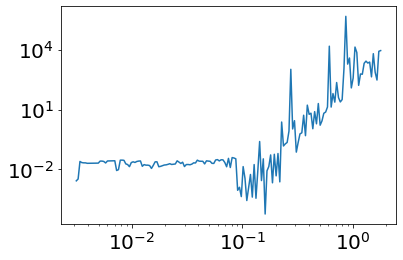

In [14]:
# Threshold eta above which max and quantiles start increasing

plt.plot(Etas[30:-3],(maxz[neps,30:-3]/mn-q[neps,30:-3]/qn)**2)
plt.xscale('log')
plt.yscale('log')

In [15]:
Etas[51+np.argmin((maxz[neps,50:-3]/mn-q[neps,50:-3]/qn)**2)]

0.16676716762659416

---
##### 3.2 Exponent

In [16]:
# With CCDF fit
mu = np.zeros((Neps,Neta,2))

cutoff = np.ones_like(Etas)*2
for j,_ in enumerate(Epsilons):
    for i,n_ in enumerate(Etas):
        z = TS[1000:,j,i]
        ecdf = ECDF( (z-np.mean(z))/np.std(z))   # because z[:,0] is z for n=1 and so on
        if np.max(np.isnan(  ecdf.x  ))==False and ecdf.x[ecdf.x>cutoff[i]][:-1].size!=0:
            mu[j,i] = 1-np.polyfit(np.log10(ecdf.x[ecdf.x>cutoff[i]][:-1]),np.log10(1-ecdf.y[ecdf.x>cutoff[i]][:-1]),1)[0] 
        else: mu[j,i] = float('NaN')

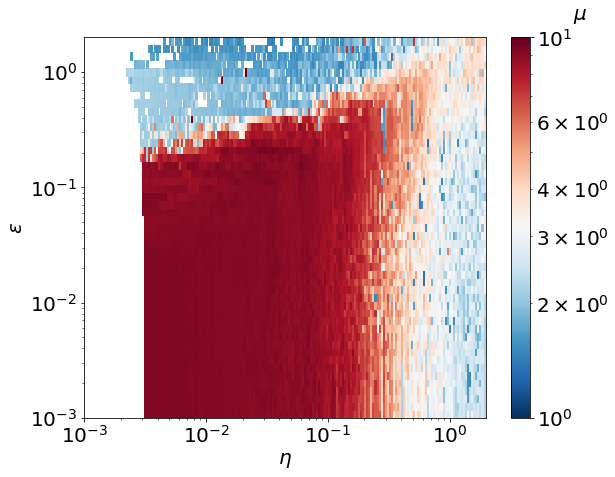

In [17]:
plt.figure(figsize=(9,7))
cmap = 'PuBu_r'
pcol=plt.pcolor(Etas,Epsilons,mu[:,:,0],norm=colors.LogNorm(vmin=1,vmax=1e1),cmap='RdBu_r')
cbar = plt.colorbar()


plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$\eta$')

cbar.set_label(r'$\mu$', labelpad=-28, y=1.08, rotation=0)

#plt.plot(Etas[:],Etas[:])

In [18]:
# With Hill estimator

In [20]:
delta = np.zeros((Neps,Neta))
for i,_ in enumerate(Epsilons):
    for j,_ in enumerate(Etas): 
        z = TS[1000:,i,j]
        OS_z = np.sort(np.abs(z[:]),axis=0)
        OS_z = OS_z[::-1]
        Nk = int(1e2)
        #ktest = np.logspace(0,np.log(np.max(OS_z[:])*.4),Nk)
        ktest = np.linspace(1,np.max(z[:])*.8,Nk)
        #ktest = np.logspace(0,3,Nk)
        mu_k = np.zeros_like(ktest)

        for l,k in enumerate(ktest):
            kmin = np.argmin(OS_z[:]>k)
            mu_k[l] = kmin/(np.sum(np.log(OS_z[:kmin]/OS_z[kmin]))) 
        
        delta[i,j] = np.nanmean(mu_k)

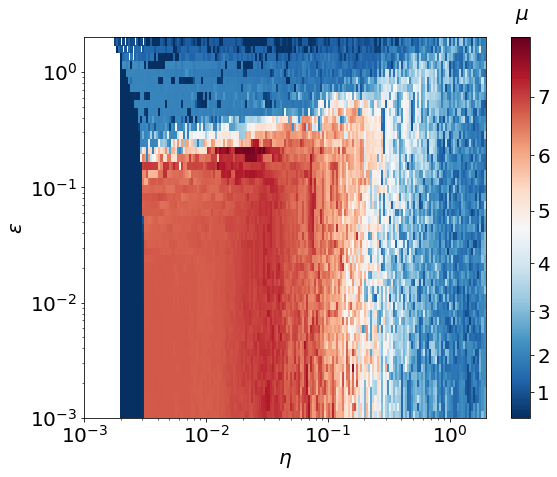

In [21]:
plt.figure(figsize=(9,7))
cmap = 'PuBu_r'
pcol=plt.pcolor(Etas,Epsilons,delta, norm=colors.PowerNorm(gamma=1.3),cmap='RdBu_r')
cbar = plt.colorbar()


plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$\eta$')

cbar.set_label(r'$\mu$', labelpad=-28, y=1.08, rotation=0)

#plt.plot(Etas[:],Etas[:])
plt.savefig('GraphsR5/mu_nc.pdf')

----
##### 3.3 Convergence time

In [22]:
ratio = np.abs(TS[2:,:,:]/TS[:-2,:,:]) # because control is turned on after one time step, we start at t=2

In [23]:
firstnan = np.argmax(np.isnan(TS[:,:,:]),axis=0)
length = len(ratio)*((firstnan==False)*1) + firstnan*(1-(firstnan==False)*1) # duration of time series = min(Niter,time of first_nan)

In [24]:
Ne = np.asarray([np.argmin((ratio[:,:,i])>1,axis=0) for i in range(Neta)]).T #First time where TS is decreasing

fit_conv =np.polyfit(np.log(Etas[40:180]),np.log(Ne[neps,40:180]/Niter),deg=1)
print(fit_conv)

[-0.9557353  -8.29535541]


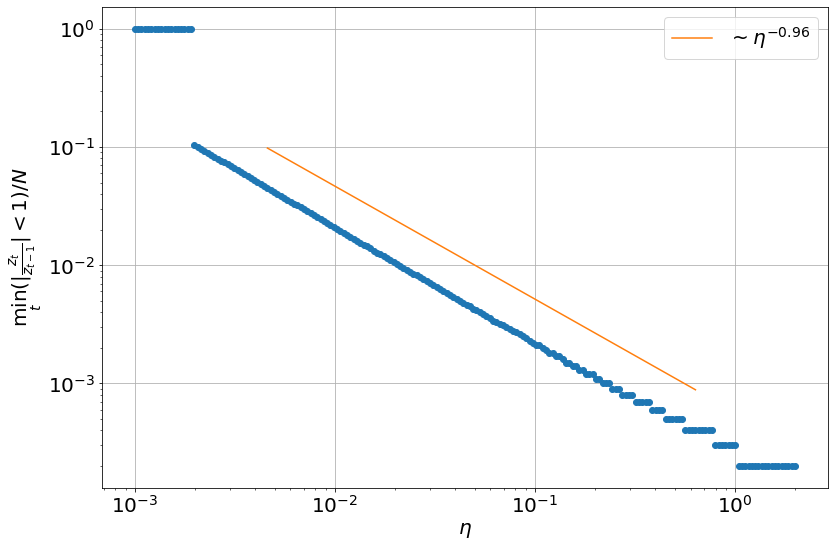

In [25]:
plt.figure(figsize=(12,8))
plt.plot(Etas,Ne[neps,:]/length[neps,:],'o')
plt.plot((Etas[40:170]),Etas[40:170]**(fit_conv[0])*np.exp(fit_conv[1]*.9),label=r'$\sim \eta^{{{:.2f}}}$'.format(fit_conv[0]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\min_t(\vert \frac{z_t}{z_{t-1}}\vert <1)/N$');
plt.legend();
plt.tight_layout()
plt.grid()
#plt.savefig('GraphsR5/nc_conv.pdf')